In [1]:
# Make sure to install the requirements with pip install -r requirements.txt
import os
os.chdir('..')
from matplotlib import pyplot as plt
import numpy as np
import torch
from lib.model import get_model_and_optim
from lib.data import prepare_nuclear_data
from lib.utils import  IO
from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import TSNE, Isomap
import seaborn as sns
import tqdm
sns.set_style('darkgrid')
sns.set_context('paper')

In [2]:
def inverse_transform(tensor, data):
    min_ = torch.from_numpy(data.regression_transformer.data_min_).to(tensor.device)
    max_ = torch.from_numpy(data.regression_transformer.data_max_).to(tensor.device)
    return tensor * (max_ - min_) + min_

def get_preds(X, model, data, batch = 200):
    preds = torch.zeros(X.shape[0], 1).to(X.device)
    with torch.no_grad():
        for i in range(0, X.shape[0], batch):
            preds_ = inverse_transform(model(X[i:i+batch]), data)
            preds_ = torch.gather(preds_, 1, X[i:i+batch, [2]])
            preds[i:i+batch] = preds_
    return preds

def get_rms(X, y, model, data):
    preds = get_preds(X, model, data)
    rms = {}
    for i, task_name in enumerate(data.output_map):
        task_mask = X[:, 2] == i
        rms[task_name] = torch.sqrt(torch.mean((preds[task_mask] - y[task_mask])**2)).item()
    return rms

# Checking RMS values as a function of how populated a sample (Z, N) is. 

In [2]:
location = f"experiments/MTL/mtl-binding100+z1+n1+radius0.02+qa200+qbm200+qbm_n200+qec200+sn200+sp200-seed0/"
args = IO.load_args(f"{location}/args.yaml")
args.DEV = "cpu"
data = prepare_nuclear_data(args)
model = get_model_and_optim(data, args)[0]
model.load_state_dict(torch.load(IO.load_latest_model(location), map_location=args.DEV))
model_name = location.split('/')[-2]

In [12]:
# get RMS for each task
mask = data.val_mask & ~torch.isnan(data.y[:, 0])
X_val = data.X[mask]
y_val = data.y[mask]

mask = data.train_mask & ~torch.isnan(data.y[:, 0])
X_train = data.X[mask]
y_train = data.y[mask]
print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Val: {X_val.shape}, {y_val.shape}")
    
rms_train = get_rms(X_train, y_train)
print(rms_train)

Train: torch.Size([14945, 3]), torch.Size([14945, 1])
Val: torch.Size([14923, 3]), torch.Size([14923, 1])
{'binding': 291.6341857910156, 'z': 0.05486823990941048, 'n': 0.05277903378009796, 'radius': 0.001535041956230998, 'qa': 31.250503540039062, 'qbm': 39.084625244140625, 'qbm_n': 49.55051803588867, 'qec': 43.10477066040039, 'sn': 26.936147689819336, 'sp': 31.381561279296875}


In [13]:
# let's split data by whether there's at least one value in the training set
import pandas as pd
train_mask = (data.train_mask & ~torch.isnan(data.y[:, 0])).view(-1, len(data.output_map))
z = data.X[::len(data.output_map), 0]
n = data.X[::len(data.output_map), 1]
intrain_df = pd.DataFrame({'z' : z, 'n' : n, 'in_train' : train_mask.sum(-1)})
num_train = intrain_df.in_train.unique()
num_train.sort()    

In [14]:
def pred_df(X, y, preds, task_idx):
    """make a df for a single task"""
    mask = X[:, 2] == task_idx
    X = X[mask].cpu().numpy()
    y = y[mask].cpu().numpy()
    preds = preds[mask].cpu().numpy()
    df = pd.DataFrame(X[:, :2], columns=['z', 'n'])
    df['value'] = y
    df['pred'] = preds
    return df

def get_rms_trainrate_df(X, y, preds):
    """make a df with train set rate of each feature and its val rms """
    rms_by_num_train = {}
    for idx, task_name in enumerate(data.output_map):
        task_df = pred_df(X, y, preds, idx)
        task_df['task'] = task_name
        merged_df = task_df.merge(intrain_df, on=['z', 'n'])
        rms_by_num_train[task_name] = {}
        for num in num_train:
            mask = merged_df.in_train == num
            rms_by_num_train[task_name][num] = np.sqrt(np.mean((merged_df[mask].value - merged_df[mask].pred)**2))
    df = pd.DataFrame(rms_by_num_train)
    df['num_train'] = num_train 
    return df

preds_val = get_preds(X_val)
rms_trainrate_df = get_rms_trainrate_df(X_val, y_val, preds_val)
rms_trainrate_df

,binding,z,n,radius,qa,qbm,qbm_n,qec,sn,sp,num_train
0,3818.791504,0.111281,0.087072,NaN,162.000916,322.469757,188.334946,737.837585,129.156967,436.427979,0
1,5707.840332,0.162661,3.336906,0.011608,611.174072,936.593262,587.707886,468.987366,281.925323,252.085785,1
2,4089.072510,0.093367,0.120105,0.010661,525.560791,645.653564,985.237183,496.098572,328.080139,477.595398,2
3,4135.493652,0.090708,0.086971,0.023507,442.002960,559.608948,909.497681,739.888245,535.424988,805.374756,3
4,2858.175049,0.076909,0.088117,0.047341,407.281372,454.052795,610.092285,558.149475,309.542297,240.105453,4
5,3073.351318,0.070368,0.082797,0.050581,364.187531,372.865448,428.500519,1053.078125,294.263336,343.556824,5
6,1772.918457,0.070245,0.063828,0.017871,448.896637,290.695251,388.757507,503.507446,349.250061,315.929871,6
7,880.514038,0.066646,0.104018,0.032779,340.350494,659.352295,687.272034,328.200134,306.801575,255.631714,7
8,663.760864,0.054925,0.049361,0.017020,254.445618,356.467133,276.940948,626.171204,214.836227,247.509644,8
9,204.761597,0.045532,NaN,NaN,NaN,NaN,48.181152,235.343750,NaN,101.712891,9


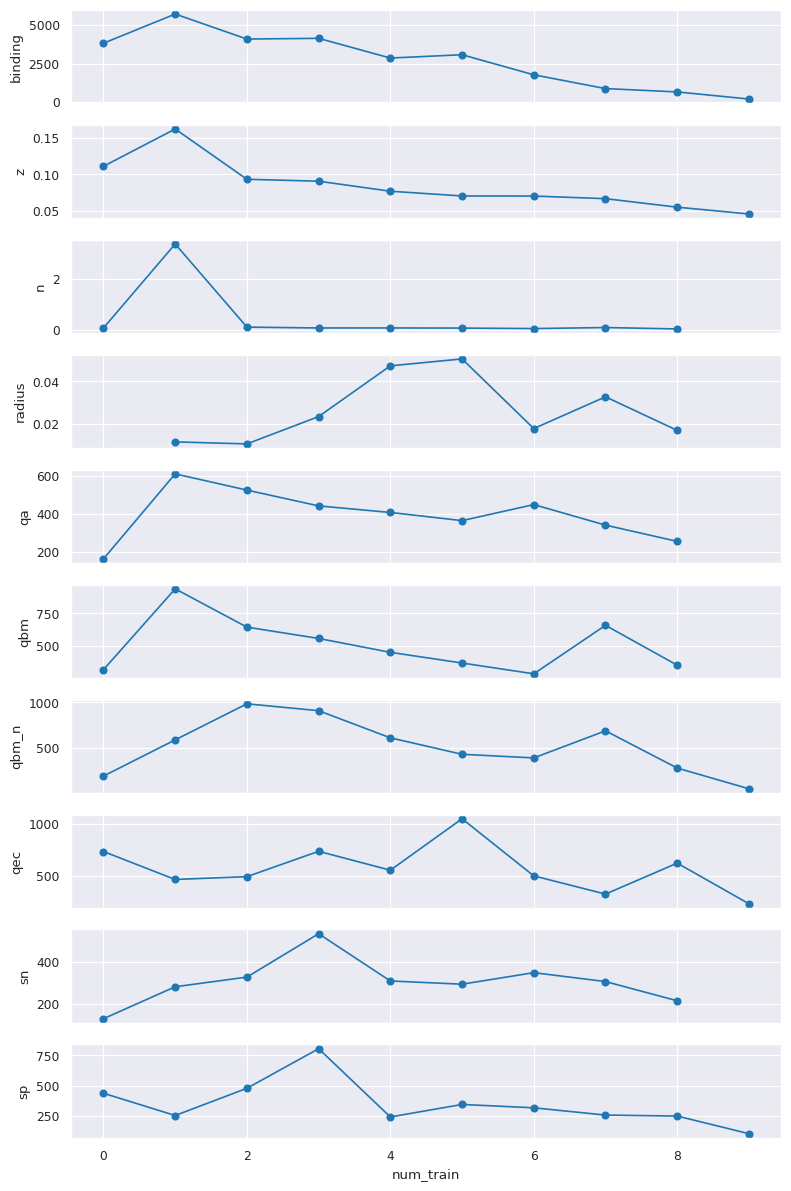

In [15]:
fig, axes = plt.subplots(len(data.output_map), 1, figsize=(8, 12), sharex=True)

for i, task_name in enumerate(data.output_map):
    axes[i].plot(rms_trainrate_df['num_train'], rms_trainrate_df[task_name], marker='o')
    axes[i].set_ylabel(task_name)

axes[-1].set_xlabel('num_train')

plt.tight_layout()
plt.show()

# RMS with and without other tasks

In [3]:
import glob
locations = glob.glob(f"/n/holyscratch01/iaifi_lab/kitouni/mech-interp-experiments/experiments/mtl/*")

keys = [l.split('/')[-1].split('-')[1] for l in locations]
def cleanup(name):
    if '+' in name: return 'all'
    while name[-1].isdigit() or name[-1] == '.':
        name = name[:-1]
    return name
keys = [cleanup(k) for k in keys]
locations = {key:l for key, l in zip(keys, locations)}
task_rms_values = {}

In [9]:
for key, location in tqdm.tqdm(locations.items()):
    print(key)
    args = IO.load_args(f"{location}/args.yaml")
    args.DEV = "cpu"
    data = prepare_nuclear_data(args)
    model = get_model_and_optim(data, args)[0]
    model.load_state_dict(torch.load(IO.load_latest_model(location), map_location=args.DEV))


    # get RMS for each task
    mask = data.val_mask & ~torch.isnan(data.y[:, 0])
    X_val = data.X[mask]
    y_val = data.y[mask]

    mask = data.train_mask & ~torch.isnan(data.y[:, 0])
    X_train = data.X[mask]
    y_train = data.y[mask]
        
    rms_train = get_rms(X_train, y_train, model, data)
    rms_val = get_rms(X_val, y_val, model, data)
    task_rms_values[key] = (rms_train, rms_val)

  0%|          | 0/12 [00:00<?, ?it/s]

control


100%|██████████| 12/12 [00:04<00:00,  2.77it/s]


In [ ]:
# # save rms values
# import pickle
# with open('experiments/MTL/task_rms_values.pkl', 'wb') as f:
#     pickle.dump(task_rms_values, f)

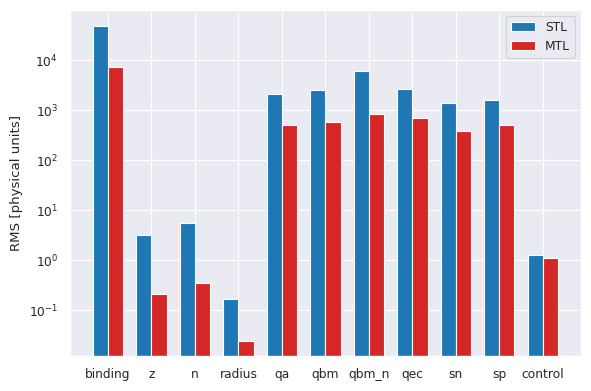

In [12]:
# plot rms values
tasks = list(task_rms_values['all'][0].keys())
stl_values = {task : task_rms_values[task][1][task] for task in tasks}
mtl_values = {task : task_rms_values['all'][1][task] for task in tasks}
#make bar plot
fig, ax = plt.subplots(figsize=(6, 4))
x = np.arange(len(tasks))
width = 0.35
ax.bar(x - width/2, stl_values.values(), width, label='STL', color='C0')
ax.bar(x + width/2, mtl_values.values(), width, label='MTL', color='C3')
ax.set_xticks(x)
ax.set_xticklabels(tasks)
ax.set_ylabel('RMS [physical units]')
ax.set_yscale('log')
ax.legend()
plt.tight_layout()
# fig.savefig('experiments/MTL/STLvsMTL.pdf')
plt.show()

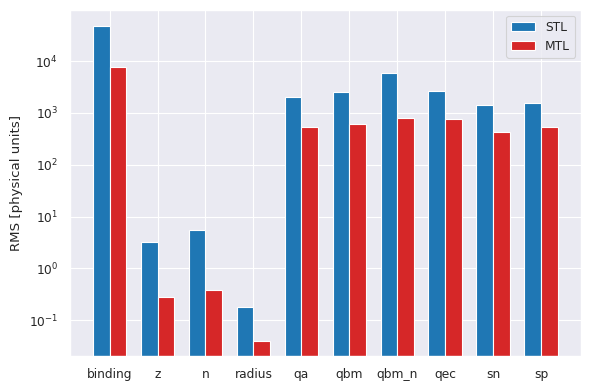

In [ ]:
# plot rms values
tasks = list(task_rms_values['all'][0].keys())
stl_values = {task : task_rms_values[task][1][task] for task in tasks}
mtl_values = {task : task_rms_values['all'][1][task] for task in tasks}
#make bar plot
fig, ax = plt.subplots(figsize=(6, 4))
x = np.arange(len(tasks))
width = 0.35
ax.bar(x - width/2, stl_values.values(), width, label='STL', color='C0')
ax.bar(x + width/2, mtl_values.values(), width, label='MTL', color='C3')
ax.set_xticks(x)
ax.set_xticklabels(tasks)
ax.set_ylabel('RMS [physical units]')
ax.set_yscale('log')
ax.legend()
plt.tight_layout()
fig.savefig('experiments/MTL/STLvsMTL.pdf')
plt.show()